# Homework 3 - Ludek Cizinsky, 377297

In this homework, we are going to work with the transformer. There are three parts of this homework.

- In the first part, we are going to implement **positional encoding** and **self-attention**  and test them on a simple text dataset which contains around 100 sentences. We will use a small transformer in this task.

- In the second part, we will detect promoters from the DNA sequences. The main difference compared to the previous task is to tokenize the DNA sequence. Thus, our task here is to build the **tokenizer** to tokenize the DNA sequence. For the model, we will continue using the small transformer.

- In the third part, we will use a **foundation model** DNABERT to perform promoter detection. In this part, you do not need to train the transformer. Instead, you need to find and load the correct pre-trained model and then use it to get the embedding of the DNA sequence. Then, you will build a simple classifier to perform promoter detection based on the DNA embedding.

## 0. Initialization

Import the packages you are going to use here.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import random
import numpy as np
from torchmetrics.classification import BinaryF1Score

import ipywidgets as widgets
from types import SimpleNamespace
from utils import data, evaluation, models, visualization, text_exercise

from sklearn.decomposition import PCA
from bhtsne import tsne
import matplotlib.pyplot as plt

import math
import os

from IPython.display import clear_output

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Set the hyperparameters.

In [3]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Positional Encoding and Self-Attention (7 pts)

### 1.1. Sinusoidal Positional Encoding (1 pt)

In this section, you are going to implement the sinusoidal positional encoding. The formula is as the following:

<div>
<img src="./imgs/positional embedding.png" width="400"/>
</div>

where $t$ is the desired position in the input and $\mathsf{\omega}_k$ follows:

<div>
<img src="./imgs/omega.png" width="200"/>
</div>

To see the details of sinusoidal positional encoding, you can check this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [6]:
class PositionalEmbedding(nn.Module):

    def __init__(self, max_position_embeddings, hidden_size, device):
        super().__init__()

        '''Construct the positional embedding.

        Args:
            max_position_embeddings (int): maximum length of the input - related to t in the previous formula
            hidden_size (int): encoding dimension - d in the previous formula
        '''

        # Account for odd hidden size dimension by assuming first we have even dimension
        # In the last step, we will just drop the last row
        is_odd = hidden_size % 2
        if is_odd:
            hidden_size += 1 

        # Compute weights for the positional embedding
        k = torch.arange(hidden_size//2, dtype=torch.float32, device=device)
        w = 1 / (10000 ** (2*k/hidden_size))

        # Compute the positional embedding
        t = torch.arange(max_position_embeddings, dtype=torch.float32, device=device)
        sin = torch.sin(torch.outer(t, w)) # n x d/2
        cos = torch.cos(torch.outer(t, w))  # n x d/2

        # Put the sin and cos together
        self.positional_embedding = torch.zeros((max_position_embeddings, hidden_size), device=device)
        self.positional_embedding[:, 0::2] = sin
        self.positional_embedding[:, 1::2] = cos

        # Drop the last row
        if is_odd:
            self.positional_embedding = self.positional_embedding[:-1, :]
        
    def forward(self, x):
        return self.positional_embedding
    
    def embedding(self):
        return self.positional_embedding

Here, you can visualize your positional encoding. If you implement everything correctly, you can get a figure that is similar to Figure 2 in this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [7]:
visualize_embedding, dimension_selector, max_len_selector = visualization.display_positional_encoding(PositionalEmbedding)
ui = widgets.HBox([max_len_selector, dimension_selector])  
out = widgets.interactive_output( visualize_embedding, {'max_len': max_len_selector, 'dimension': dimension_selector})
display(ui, out)

Output()

### 1.2. Self-Attention Mechanism (5 pts)

In this section, you are going to implement the self-attention mechanism. Please check the section 'Self-Attention in Detail' in this [link](https://jalammar.github.io/illustrated-transformer/) for the details of self-attention mechanism. (We encourage you to carefully go through the link since it is a very good tutorial for transformer.)

The specific steps will be provided in the comments of the following code. (The steps are only for reference. You do need to follow the steps if you have a better way to implement it.)

In [10]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )
        self.output_attentions = config.output_attentions
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):

        # Resulting shape: (batch_size, sequence_length, all_head_size)
        mixed_key_layer = self.key(hidden_states)
        mixed_query_layer = self.query(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # Resulting shape: (batch_size, num_attention_heads, sequence_length, attention_head_size)
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Resulting shape: (batch_size, num_attention_heads, sequence_length, sequence_length)
        # For each input token, we have unnormalized scores for all other tokens in the input sequence
        attention_scores = query_layer @ key_layer.transpose(-1, -2) / math.sqrt(self.attention_head_size)
        
        # Explanation of attention_mask: https://lukesalamone.github.io/posts/what-are-attention-masks/
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores
        attention_probs = F.softmax(attention_scores, dim=-1)

        # Apply dropout
        attention_probs = self.dropout(attention_probs)

        # (optional) Apply head mask if provided
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # Reweight each token embeddings by the attention scores
        # Shape: (batch_size, num_attention_heads, sequence_length, attention_head_size)
        context_layer = attention_probs @ value_layer

        # Concatenate all the attention heads together
        head_outputs = torch.split(context_layer, 1, dim=1)
        context_layer = torch.cat(head_outputs, dim=-1).squeeze(1)

        # Get the output
        outputs = (context_layer, attention_probs) if self.output_attentions else (context_layer,)
        return outputs

Let's test your implementation using simple text data! First, let's load the data.

We use a small dataset in this homework for a shorter training time.

In [11]:
# ChatGPT generated text data about BERT
text = text_exercise.get()
sentences_df, vocab = data.to_sentence_df(text)

After loading the data, you can train your model. Here we train our model using masked token prediction.

Hint: The final model accuracy should be higher than 0.9.

In [12]:
text_max_len = 11

text_config = SimpleNamespace(
        vocab_size=len(vocab),
        hidden_size=60,
        max_position_embeddings=text_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=2,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=1,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=False,
        pruned_heads = {},
        initializer_range=0.02,
        device="cpu"
    )

tokenizer = data.TextTokenizer(vocab)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(sentences_df, tokenizer, k=1, max_len=text_max_len, noise_rate=0.4)

model = models.BertForMaskedLM(config=text_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

for epoch in range(200):
    optimizer.zero_grad()
    loss, outputs, attentions = model(
        input_ids=input_ids,
        token_type_ids=segment_ids,
        masked_lm_labels=masked_lm_labels,
        attention_mask=attention_masks
    )
    if (epoch + 1) % 20 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

print(f"Final model accuracy: {evaluation.masked_label_accuracy(labels, labels_idx, outputs.data)}")

Number of trainable model parameters: 64910
Epoch: 0020 loss = 4.302866
Epoch: 0040 loss = 3.678340
Epoch: 0060 loss = 3.141427
Epoch: 0080 loss = 2.638857
Epoch: 0100 loss = 2.167831
Epoch: 0120 loss = 1.691045
Epoch: 0140 loss = 1.259182
Epoch: 0160 loss = 0.889033
Epoch: 0180 loss = 0.579525
Epoch: 0200 loss = 0.357437
Final model accuracy: 1.0


### 1.3. Visualize Attention (1 pt)

Here, you can visualize the self-attention. 

Question: Can you interpret the visualization of the self-attention?

**Answer:** In each row, we have weights denoting the importance of each token in the input sequence for the current token (ith token). The darker the color, the more important the token is. We can see that the model pays more attention to the tokens that are closer to the current token. For instance, given sample `11`, the most important tokens for word they are `they`, `one` and `at`.

In [13]:
visualize_attention, sample_id_selector = visualization.display_attantion(attentions=attentions, input_ids=input_ids, tokenizer=tokenizer)
widgets.interactive(visualize_attention, sample_id=sample_id_selector)

interactive(children=(Dropdown(description='Sample:', options=(5, 8, 11, 13, 18, 24, 26, 29, 31, 35, 37, 38, 6…

### 1.4. Train on small Wikitext Dataset

Here, you can **optionally** test your model on the smallest wikitext dataset. You should get an test accuracy around 0.4 after training 50 epochs.

This part is only for you to test your code. You can choose to run it or not. It takes around 1 hour to train the model for 50 epochs on the smallest wikitext dataset with Google Colab.

In [14]:
# text_exercise.train_wikitext(device, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)

## 2. Promoter detection (7 pts)

In this section, we detect promoter in DNA sequence.

A promoter is a region of DNA upstream of a gene where relevant proteins (such as RNA polymerase and transcription factors) bind to initiate transcription of that gene. Promoter detection is to identify if there are promoter regions in the given DNA sequence. We have covered this in the lecture. (If you are interested in the promoter, you can check this [link](https://www.genome.gov/genetics-glossary/Promoter) for more details.)

Here, we use a transformer and a classifier. The transformer first embeds the DNA sequences into features, and then the classifier detects the promoter based on the features.

The main difference between text and DNA sequence is how to tokenize the sequence. Thus, you need to implement a tokenizer for the DNA sequence.

### 2.1. DNA Tokenizer (1 pts)

Here, you will implement the DNA tokenizer the same as in DNABERT. Please check this [paper](https://academic.oup.com/bioinformatics/article/37/15/2112/6128680) for implementation details. Also, you need to check the data type and shape for both input and output.

In [15]:
class DNATokenizer(data.Tokenizer):
    def __init__(self, k, vocab, unknown="[UNK]"):
        super().__init__(vocab, unknown)

        # self.k is the k of k-mers
        self.k = k

    def _parse_text(self, text):
        # Split the text into k-mers and add special tokens to the start and end of the sequence
        n = len(text)
        return ['[CLS]'] + [text[i:i + self.k] for i in range(n - self.k + 1)] + ['[SEP]']

### 2.2. Test BERT on DNA Sequence

In this section, you will train BERT on DNA sequence to learn the embedding of DNA sequence. The code is provided below and you do not need to write anything.

Hint: the final evaluation accuracy should be higher than 0.2.

In [16]:
kmer = 3
mask_length = kmer
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]

raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

dna_max_len = 300
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
if not os.path.exists('models/bert_longmask.pth'):
  print("Training the model...")
  model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
  optimizer = optim.AdamW(model.parameters(), lr=0.002)
  print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

  for epoch in range(50):
    total_train_loss = 0
    model.train()
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
      optimizer.zero_grad()
      loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
      )
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    if (epoch + 1) % 10 == 0:
      model.eval()
      total_eval_loss = 0
      for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
        with torch.no_grad():
          loss, outputs, hidden_states, _ = model(
            input_ids=batch_input_ids.to(device),
            token_type_ids=batch_segment_ids.to(device),
            masked_lm_labels=batch_masked_lm_labels.to(device),
            attention_mask=batch_attention_mask.to(device)
          )
          if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
            print("found patting", batch_attention_mask.sum())
          total_eval_loss += loss.item()
      avg_eval_loss = total_eval_loss / len(test_loader)
      print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

  # Save the trained model
  os.makedirs('models', exist_ok=True)
  torch.save(model, 'models/bert_longmask.pth')

# Load the trained model
else:
  print("Loading the trained model...")
  model = torch.load('models/bert_longmask.pth')
  print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Loading the trained model...
Number of trainable model parameters: 118869
Train Acc = 0.252133 Eval Acc = 0.242678


### 2.3. Visualize the Attentions (1 pt)

Here, you can visualize the self-attention. 

Question: compare the visualization to Section 1.3, what can you find here? How do you explain it?

**Answer:** We can see a clear diagonal pattern in the visualization. This demonstrates that each `k-mer`'s embedding is defined by the closest following `k-mers`. This is in contrast to 1.3 where the model also payed attention to previuous tokens.

In [17]:
visualize_attention, sample_id_selector, layer_selector, head_selector = visualization.display_multi_attantion(attentions=last_test_attention, tokenizer=tokenizer, input_ids=input_ids,  layers=range(1, num_layers+1),  heads=range(1, num_heads+1))
ui = widgets.HBox([sample_id_selector, layer_selector, head_selector])  
out = widgets.interactive_output(visualize_attention, {'sample_id': sample_id_selector, 'layer': layer_selector, 'head': head_selector})
display(ui, out)

Output()

### 2.4. Use your pretrained model for promoter detection (5 pts)

You already have the embeddings for the DNA sequence. Now, you are going to build a classifier based on the DNA embeddings. The classifier is to perform promoter detection. Specifically, the DNA sequence will be classified into *'contains promoter'* or *'does not contain promoter'*.

Hint: 
- We now want to annotate data (get the label for each sample), not predict masked data anymore!
- You can reuse some parts of the code in the previous sections, e.g. dataloader and training pipeline in Section 2.2.
- If you implement the previous section correctly (the Eval Acc > 0.2 in Section 2.2), you already have an pre-trained object named 'model' of class models.BertForMaskedLM. You can directly use it.
- The evaluation accuracy of this task should be around 0.6.

In [18]:
# Define a binary classifier
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedder):
        super().__init__()
        self.embedder = embedder
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

      # Get the output embeddings of BertForMaskedLM
      hidden_states = self.embedder(x)[1]

      # Get the output embeddings
      outputs = hidden_states[-1]

      # Use the [CLS] token embedding
      x = outputs[:, 0, :]

      # Run the classifier
      x = self.linear1(x)
      x = self.linear2(x)
      x = self.sigmoid(x)

      return x.squeeze(1)

In [19]:
# Load the data (without masks indeed)
input_ids, labels = data.generate_labeled_data(raw_training_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)
test_input_ids, test_labels = data.generate_labeled_data(raw_test_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)

# Convert labels to float
labels = labels.float()
test_labels = test_labels.float()

# Define data loaders
train_dataset = TensorDataset(input_ids, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Train the model first
criterion = nn.CrossEntropyLoss()
if not os.path.exists('models/promoter_clf.pth'):

  print("Training the model...")
  # Freeze the weights of the embedder model
  for param in model.parameters():
      param.requires_grad = False

  # Define the classifier
  clf = BinaryClassifier(input_size=60, hidden_size=30, output_size=1, embedder=model).to(device)
  clf_optimizer = optim.AdamW(clf.parameters(), lr=1e-2)

  # Train the classifier
  clf.train()
  for epoch in range(50):

    # Training
    total_train_loss = 0
    preds = []
    labs = []
    for batch_input_ids, batch_labels in train_loader:

      # Reset the gradients
      clf_optimizer.zero_grad()

      # Get the output of the classifier
      batch_output = clf(batch_input_ids)

      # Compute the loss
      loss = criterion(batch_output.to(device), batch_labels.to(device))

      # Add prediction and labels
      bpred = (batch_output > 0.5).float().tolist()
      blabs = batch_labels.tolist()
      preds.extend(bpred)
      labs.extend(blabs)

      # Backpropagation
      loss.backward()
      clf_optimizer.step()
      total_train_loss += loss.item()

    # Evaluate the epoch
    preds, labs = np.array(preds), np.array(labs)
    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = np.mean(preds == labs)
    if (epoch + 1) % 10 == 0:
      print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'train acc =', '{:.6f}'.format(train_acc))

  # Save the trained model
  os.mkdir('models', exist_ok=True)
  torch.save(clf, 'models/promoter_clf.pth')

# Load the trained model
else:
  print("Loading the trained model...")
  clf = torch.load('models/promoter_clf.pth')

# Evaluation
total_test_loss = 0
preds = []
labs = []
clf.eval()
for batch_input_ids, batch_labels in test_loader:

  # Get the output of the classifier
  batch_output = clf(batch_input_ids)

  # Compute the loss
  loss = criterion(batch_output.to(device), batch_labels.to(device))

  # Add prediction and labels
  bpred = (batch_output > 0.5).float().tolist()
  blabs = batch_labels.tolist()
  preds.extend(bpred)
  labs.extend(blabs)

  total_test_loss += loss.item()

preds, labs = np.array(preds), np.array(labs)
avg_test_loss = total_test_loss / len(test_loader)
test_acc = np.mean(preds == labs)
print('Test cost =', '{:.6f}'.format(avg_test_loss), 'test acc =', '{:.6f}'.format(test_acc))


Loading the trained model...
Test cost = 308.532658 test acc = 0.586000


### 2.5. Additional question (1 pt)

Now we change mask_length = 1 (already changed, you do not need to implement anything).
Let's run the code below and check the accuracy.

Question: What is the final masked token prediction accuracy? How do you explain this?

**Answer:** It is relatively high (92 %) compare to the training with 3 masked tokens. Since in this case we only mask one token, the model has much more context to predict the masked token. In this particular, it has 3 times more context than in the previous case. Therefore, out of the total of `300` tokens, only `15` are masked in contrast to `45`. Further, as we saw in the visualization `2.3`, the model pays attention to the closest following k-mers to the current one. Therefore, if we have 3 subsequent k-mers masked, then for instance the first masked k-mer loses very important information from the following k-mers. This is not the case when we mask only one k-mer.

In [21]:
kmer = 3
mask_length = 1

dna_max_len = 300
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

tokenizer = DNATokenizer(k=3, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
if not os.path.exists('models/bert_shortmask.pth'):
  print("Training the model...")
  model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
  optimizer = optim.AdamW(model.parameters(), lr=0.002)
  print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

  for epoch in range(50):
    total_train_loss = 0
    model.train()
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
      optimizer.zero_grad()
      loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
      )
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    if (epoch + 1) % 10 == 0:
      model.eval()
      total_eval_loss = 0
      for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
        with torch.no_grad():
          loss, outputs, hidden_states, _ = model(
            input_ids=batch_input_ids.to(device),
            token_type_ids=batch_segment_ids.to(device),
            masked_lm_labels=batch_masked_lm_labels.to(device),
            attention_mask=batch_attention_mask.to(device)
          )
          if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
            print("found patting", batch_attention_mask.sum())
          total_eval_loss += loss.item()
      avg_eval_loss = total_eval_loss / len(test_loader)
      print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

  # Save the trained model
  os.mkdir('models', exist_ok=True)
  torch.save(model, 'models/bert_shortmask.pth')

else:
  print("Loading the trained model...")
  model = torch.load('models/bert_shortmask.pth')
  print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Loading the trained model...
Number of trainable model parameters: 118869
Train Acc = 0.921650 Eval Acc = 0.923077


## 3. Using foundation model (5 pts)

### 3.1. Introduction

In this section, we aim to use a foundation model, DNABERT, to perform promoter detection.
A foundation model is a model pretrained on large datasets. Foundation models serve as the foundational building blocks upon which various applications can be constructed.

Here, we use DNABERT as the foundation model. We first apply it on DNA sequence to get the embedding. Then, we train a classifier on the embedding as in Section 2. Please follow this [link](https://github.com/Zhihan1996/DNABERT_2) to load the foundation model.

### 3.2. Implementation

**Consider this situation:** You get a dataset about promoter detection, and you build your model to perform the task as in Section 2. However, the performance is not good since the model is not strong enough. Suddenly, you think we can use a large pre-trained model to embed DNA sequences. Then, you search online and find the pre-trained model [DNABERT](https://github.com/Zhihan1996/DNABERT_2). Now, you want to perform promoter detection using the pre-trained DNABERT.

There is no coding framework in this section. Just make things work (get good test accuracy) using the pre-trained model!

Hint: 
- We encourage you to create a **new environment** following the instructions of Section 3 in this [link](https://github.com/Zhihan1996/DNABERT_2). (When you face the error "The model class you are passing has a config_class attribute that is not consistent with the config class you passed ...", creating a new environment can save you.)
- Section 4 in this [link](https://github.com/Zhihan1996/DNABERT_2) shows you how to load and use the pre-trained foundation model.

a. Load the dataset.

In [24]:
# To be able to run this module independently of the previous one
class DNATokenizer(data.Tokenizer):
    def __init__(self, k, vocab, unknown="[UNK]"):
        super().__init__(vocab, unknown)

        # self.k is the k of k-mers
        self.k = k

    def _parse_text(self, text):
        n = len(text)
        return ['[CLS]'] + [text[i:i + self.k] for i in range(n - self.k + 1)] + ['[SEP]']

In [25]:
# Define vocabulary (same as in section 2)
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]

# Load raw data
raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

# Define the tokenizer
kmer = 3
tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)

# Define training hyperparameters
dna_max_len = 300
dataset_size = 1000
batch_size = 128

# Load the data (without masks indeed)
input_ids, labels = data.generate_labeled_data(raw_training_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)
test_input_ids, test_labels = data.generate_labeled_data(raw_test_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)

# Convert labels to float
labels = labels.float()
test_labels = test_labels.float()

# Define data loaders
train_dataset = TensorDataset(input_ids, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

b. Get the embeddings of the DNA sequences using pretrained model.

Hint: 
- This step can take some time. Thus, you can start with a small sample size, and then increase it when you have made sure that everything works correctly.
- After getting the embeddings, you can save them so that you can directly load them next time without running the foundation model.

In [26]:
# Define helper functions
def save_embeddings(loader, model, path):
    for i, data in enumerate(loader):
        # Get the input 
        batch_input_ids, batch_labels = data

        # Get the output
        hidden_states = model(batch_input_ids)[0]
        
        # Aggregate the embeddings
        x_cls = hidden_states[:, 0, :] # Use the [CLS] token embedding
        x_mean = hidden_states.mean(dim=1)
        x_max = hidden_states.max(dim=1)[0] 

        # Save
        torch.save(x_cls, os.path.join(path, f"{i}_emb_cls.pth"))
        torch.save(x_mean, os.path.join(path, f"{i}_emb_mean.pth"))
        torch.save(x_max, os.path.join(path, f"{i}_emb_max.pth"))
        torch.save(batch_labels, os.path.join(path, f"{i}_labels.pth"))

def load_embeddings(path, n_batches, aggregate="cls"):
    embeddings = []
    labels = []
    for i in range(n_batches):
        embeddings.append(torch.load(os.path.join(path, f"{i}_emb_{aggregate}.pth")))
        labels.append(torch.load(os.path.join(path, f"{i}_labels.pth")))
    return embeddings, labels

In [27]:
# Load the pretrained model
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# Freeze the weights of the pretrained model
for param in model.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should prob

In [28]:
# Save the training embeddings
if not os.path.exists(os.path.join("embeddings", "dnabert", "train", "0_labels.pth")):
    # First create the path
    os.makedirs(os.path.join("embeddings", "dnabert", "train"), exist_ok=True)

    # Save the embeddings 
    print("Saving dnabert train embeddings")
    save_embeddings(train_loader, model, os.path.join("embeddings", "dnabert", "train"))

# Save the test embeddings
if not os.path.exists(os.path.join("embeddings", "dnabert", "test", "0_labels.pth")):
    # First create the path
    os.makedirs(os.path.join("embeddings", "dnabert", "test"), exist_ok=True)

    # Save the embeddings
    print("Saving dnabert test embeddings")
    save_embeddings(test_loader, model, os.path.join("embeddings", "dnabert", "test"))

nds)
Iteration 700: error is 1.396656 (50 iterations in 0.30 seconds)
Iteration 750: error is 1.391982 (50 iterations in 0.30 seconds)
Iteration 800: error is 1.387492 (50 iterations in 0.30 seconds)
Iteration 850: error is 1.383018 (50 iterations in 0.31 seconds)
Iteration 900: error is 1.379494 (50 iterations in 0.33 seconds)
Iteration 950: error is 1.376555 (50 iterations in 0.31 seconds)
Iteration 999: error is 1.371634 (50 iterations in 0.32 seconds)
Fitting performed in 6.27 seconds.


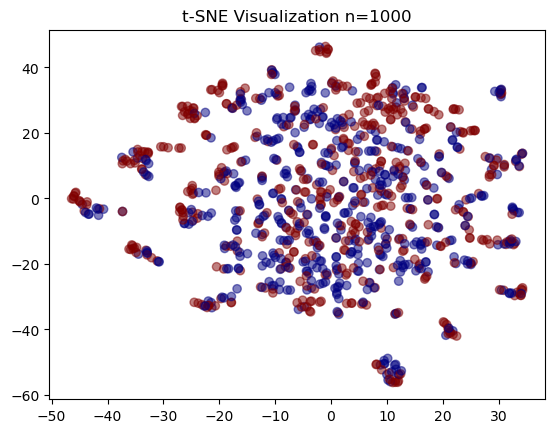

In [50]:
# Load All Training data into memory
all_emb, all_lab = load_embeddings(os.path.join("embeddings", "dnabert", "train"), len(train_loader), aggregate="cls")
emb, lab = np.empty((0, all_emb[0].shape[1])), np.empty(0)
for i in range(len(train_loader)):
    emb_i, lab_i = all_emb[i].numpy().astype(np.float64), all_lab[i].numpy().astype(int)
    emb, lab = np.concatenate((emb, emb_i), axis=0), np.concatenate((lab, lab_i), axis=0)

# Choose only a subset
n = min(len(emb), 1000)
emb, lab = emb[:n], lab[:n]
print(emb.shape, lab.shape)

# Reduce the dimensionality of the embeddings
pca = PCA(n_components=100)
reduced_data = pca.fit_transform(emb)

# Apply t-SNE on the reduced data
embedded_data = tsne(reduced_data, rand_seed=seed, perplexity=10, theta=0.5)
clear_output(wait=True)

# Visualize the result
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=lab, cmap=plt.cm.get_cmap("jet", 2), alpha=0.5)
plt.title(f't-SNE Visualization n={n}')
plt.show()

c. Train a classifier.

Hint: It is easy to overfit on the training set. Try to avoid overfitting.

In [88]:
# Load the embeddings
train_emb, train_lab = load_embeddings(os.path.join("embeddings", "dnabert", "train"), len(train_loader), aggregate="max")
test_emb, test_lab = load_embeddings(os.path.join("embeddings", "dnabert", "test"), len(test_loader), aggregate="max")

In [89]:
# Define the classifier
class DnaBertHead(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_rate)
 
    def forward(self, x):

      x = self.linear1(x)
      x = self.batchnorm(x)
      x = self.linear2(x)
      x = self.sigmoid(x)
      x = self.dropout(x)

      return x.squeeze(1)

In [116]:
# Train the model first
criterion = nn.CrossEntropyLoss()
if True or not os.path.exists('models/promoter_clf2.pth'):

  print("Training the model...")
  # Define the classifier
  clf = DnaBertHead(input_size=768, hidden_size=50, output_size=1, dropout_rate=1e-2).to(device)
  clf_optimizer = optim.AdamW(clf.parameters(), lr=1e-4, weight_decay=1e-6) # weight_decay is L2 regularization
  scheduler = StepLR(clf_optimizer, step_size=50, gamma=1.75)

  # Train the classifier
  clf.train()
  for epoch in range(750):

    # Training
    total_train_loss = 0
    preds = []
    labs = []
    for i in range(len(train_loader)):
      
        # Get the input
        batch_input_ids, batch_labels = train_emb[i], train_lab[i]

        # Reset the gradients
        clf_optimizer.zero_grad()

        # Get the output of the classifier
        batch_output = clf(batch_input_ids)

        # Compute the loss
        loss = criterion(batch_output.to(device), batch_labels.to(device))

        # Add prediction and labels
        bpred = (batch_output > 0.5).float().tolist()
        blabs = batch_labels.tolist()
        preds.extend(bpred)
        labs.extend(blabs)

        # Backpropagation
        loss.backward()
        clf_optimizer.step()
        total_train_loss += loss.item()

    scheduler.step()
    # Evaluate the epoch
    preds, labs = np.array(preds), np.array(labs)
    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = np.mean(preds == labs)
    if (epoch + 1) % 10 == 0:
      print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'train acc =', '{:.6f}'.format(train_acc))

  # Save the trained model
  os.makedirs("models", exist_ok=True)
  torch.save(clf, 'models/promoter_clf2.pth')

# Load the trained model
else:
  print("Loading the trained model...")
  clf = torch.load('models/promoter_clf2.pth')

Training the model...
Epoch: 0010 train cost = 297.566921 train acc = 0.824000
Epoch: 0020 train cost = 294.288555 train acc = 0.890000
Epoch: 0030 train cost = 292.119740 train acc = 0.922000
Epoch: 0040 train cost = 290.517210 train acc = 0.936000
Epoch: 0050 train cost = 289.306087 train acc = 0.952000
Epoch: 0060 train cost = 288.008297 train acc = 0.968000
Epoch: 0070 train cost = 287.185337 train acc = 0.973000
Epoch: 0080 train cost = 286.413740 train acc = 0.978000
Epoch: 0090 train cost = 285.933298 train acc = 0.980000
Epoch: 0100 train cost = 286.006224 train acc = 0.975000
Epoch: 0110 train cost = 285.276928 train acc = 0.982000
Epoch: 0120 train cost = 285.460829 train acc = 0.977000
Epoch: 0130 train cost = 285.292034 train acc = 0.978000
Epoch: 0140 train cost = 285.091099 train acc = 0.980000
Epoch: 0150 train cost = 285.040337 train acc = 0.980000
Epoch: 0160 train cost = 284.911972 train acc = 0.981000
Epoch: 0170 train cost = 285.089981 train acc = 0.978000
Epoch: 01

In [117]:
# Evaluation
total_test_loss = 0
preds = []
labs = []
clf.eval()
for i in range(len(test_loader)):
    # Get the input
    batch_input_ids, batch_labels = test_emb[i], test_lab[i]

    # Get the output of the classifier
    batch_output = clf(batch_input_ids)

    # Compute the loss
    loss = criterion(batch_output.to(device), batch_labels.to(device))

    # Add prediction and labels
    bpred = (batch_output > 0.5).float().tolist()
    blabs = batch_labels.tolist()
    preds.extend(bpred)
    labs.extend(blabs)

    total_test_loss += loss.item()

preds, labs = np.array(preds), np.array(labs)
avg_test_loss = total_test_loss / len(test_loader)
test_acc = np.mean(preds == labs)
print('Test cost =', '{:.6f}'.format(avg_test_loss), 'test acc =', '{:.6f}'.format(test_acc))

Test cost = 304.767906 test acc = 0.666000


---